In [32]:
import os

import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import albumentations as A


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
mask_path = '/content/gdrive/My Drive/rosneft/seismic_challenge_train(masks).csv'
train_path = '/content/gdrive/My Drive/rosneft/images'

masks = pd.read_csv(mask_path)

In [25]:
 def rle2mask(mask_rle, shape):
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype = int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_img_mask(name_img, train_path, train, one_chanell=False):
    if one_chanell:
        img = np.expand_dims(cv2.imread(os.path.join(train_path, name_img), cv2.IMREAD_GRAYSCALE), axis=2)
    else:
        img = cv2.imread(os.path.join(train_path, name_img))
    masks = [rle2mask(rle, shape = (img.shape[1], img.shape[0])) 
                for i, rle in enumerate(train[train['ImageId'] == name_img]['EncodedPixels'])]
    mask = np.stack(masks, axis=-1).astype('float')
    if mask.shape[-1] != 1:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)
    return img, mask

image name: xline_2400.png
size original image: (384, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


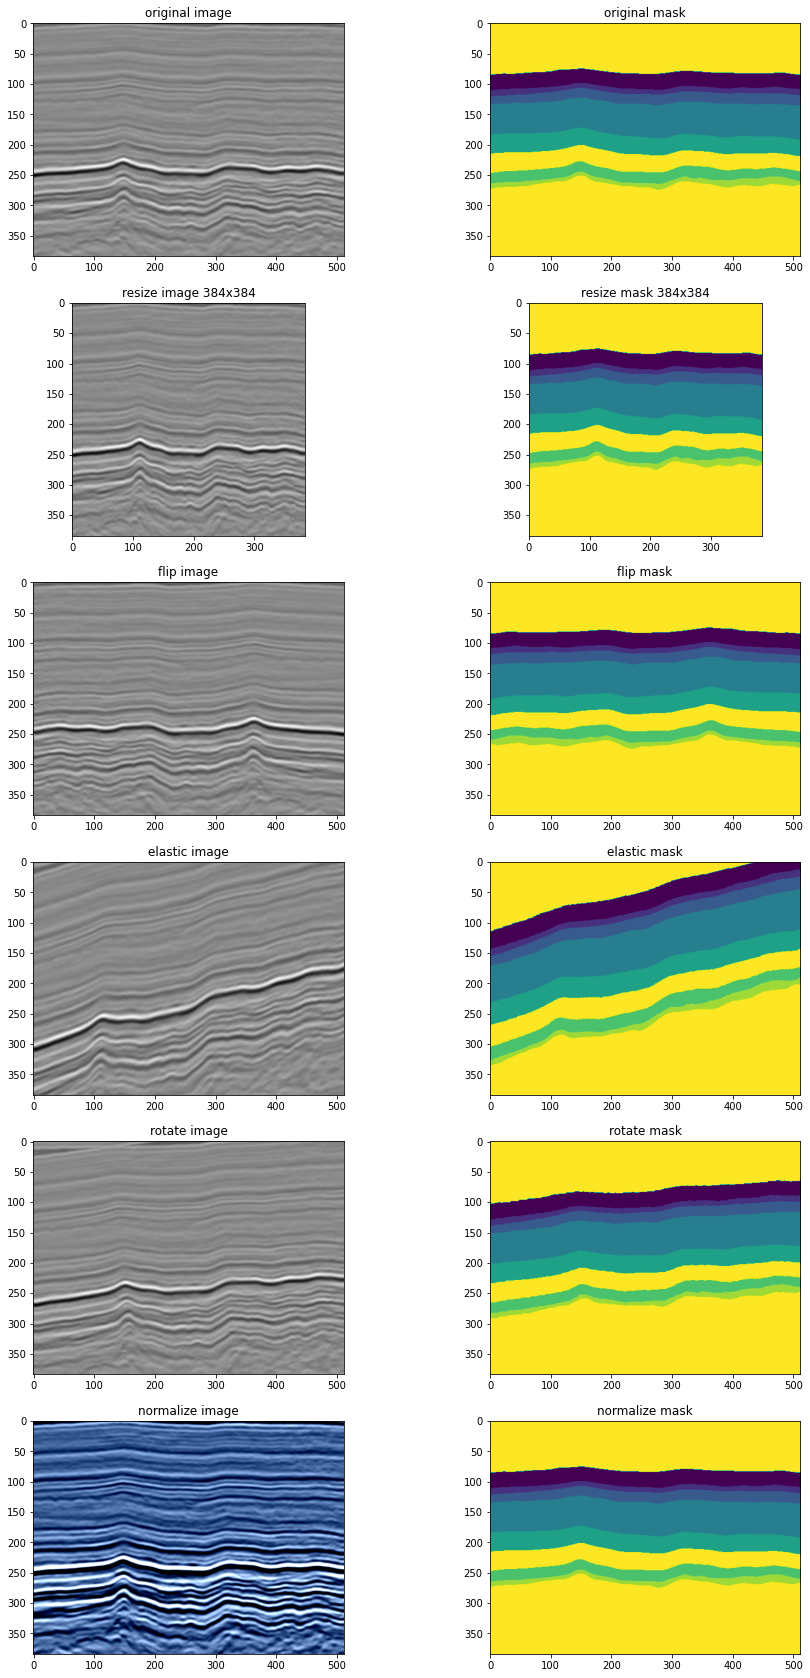

In [37]:
img_name = masks.ImageId.unique()[-1]
print('image name:', img_name)
img, mask = read_img_mask(img_name, train_path, masks)
print('size original image:', img.shape)


def plot(ax, title_img, title_mask, aug):
    img, _mask = aug['image'], aug['mask']
        
    ax[0].imshow(img)
    ax[0].set_title(title_img)

    ax[1].imshow(np.argmax(_mask, axis=-1))
    ax[1].set_title(title_mask)


img_title = ['original image', 'resize image 384x384', 'flip image', 
             'elastic image', 'rotate image', 'normalize image']
mask_title = ['original mask', 'resize mask 384x384', 'flip mask', 'elastic mask',
              'rotate mask', 'normalize mask']

fig, ax = plt.subplots(len(img_title), 2, figsize=(15, 30))

origin = A.Compose([])(image=img, mask=mask)
resize = A.Compose([A.Resize(384, 384)])(image=img, mask=mask)
flip = A.Compose([A.HorizontalFlip(p = 1)])(image=img, mask=mask)
elastic = A.Compose([A.ElasticTransform(p=1)])(image=img, mask=mask)
rotate = A.Compose([A.Rotate(limit=20, p=1)])(image=img, mask=mask)
normalize = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])(image=img, mask=mask)

aug = [origin, resize, flip, elastic, rotate, normalize]
for a in zip(ax, img_title, mask_title, aug): plot(*a)